Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

Image Loading and Segmentation

In [7]:
import os
import numpy as np
import cv2

def load_and_preprocess_images(data_dir, target_size=(128, 128)):
    images = []
    labels = []
    label_map = {'HDPE': 0, 'LDPE': 1, 'Other': 2, 'PET': 3, 'PP': 4, 'PS': 5, 'PVC': 6}
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                img = img.astype(np.uint8)  
                images.append(img)
                labels.append(label_map[label])
    
    return np.array(images), np.array(labels)

def segment_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [largest_contour], 0, 255, -1)
        segmented = cv2.bitwise_and(image, image, mask=mask)
        return segmented
    else:
        return image

# Usage
data_dir = 'images'
images, labels = load_and_preprocess_images(data_dir)

# Apply segmentation to all images
segmented_images = np.array([segment_image(img) for img in images])

print(f"Loaded {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Image dtype: {images[0].dtype}")
print(f"Segmented {len(segmented_images)} images")

Loaded 700 images
Image shape: (128, 128, 3)
Image dtype: uint8
Segmented 700 images


Data Augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming we want to increase our dataset by a factor of 5
augmentation_factor = 5
augmented_images = []
augmented_labels = []

for image, label in zip(segmented_images, labels):
    image = image.reshape((1,) + image.shape)
    i = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= augmentation_factor:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented data
X = np.concatenate((segmented_images, augmented_images))
y = np.concatenate((labels, augmented_labels))

Feature Extraction

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 16,813,895
Trainable params: 2,099,207
Non-trainable params: 14,714,688
_____________________________________

Model Compilation and Training

Epoch 1/50
84/84 [==============================] - 17s 92ms/step - loss: 11.9279 - accuracy: 0.3002 - val_loss: 3.6767 - val_accuracy: 0.5149
Epoch 2/50
84/84 [==============================] - 8s 92ms/step - loss: 3.4160 - accuracy: 0.5376 - val_loss: 2.2161 - val_accuracy: 0.5938
Epoch 3/50
84/84 [==============================] - 8s 100ms/step - loss: 1.7035 - accuracy: 0.6473 - val_loss: 1.7717 - val_accuracy: 0.6488
Epoch 4/50
84/84 [==============================] - 9s 104ms/step - loss: 1.0276 - accuracy: 0.7400 - val_loss: 1.5174 - val_accuracy: 0.6756
Epoch 5/50
84/84 [==============================] - 9s 104ms/step - loss: 0.7409 - accuracy: 0.7924 - val_loss: 1.3836 - val_accuracy: 0.6935
Epoch 6/50
84/84 [==============================] - 10s 117ms/step - loss: 0.5783 - accuracy: 0.8430 - val_loss: 1.3451 - val_accuracy: 0.6964
Epoch 7/50
84/84 [==============================] - 10s 116ms/step - loss: 0.4080 - accuracy: 0.8646 - val_loss: 1.3026 - val_accuracy: 0.7113
Epoc

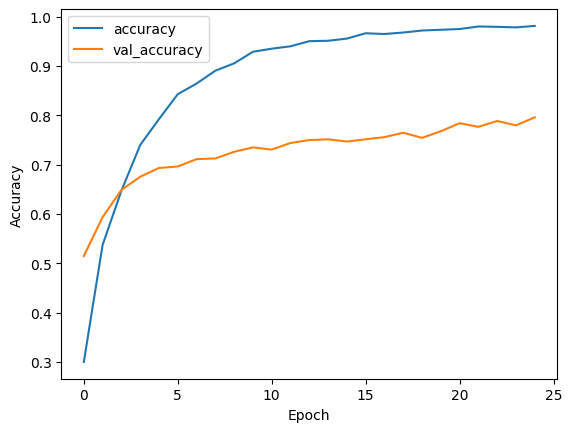

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, 7)
y_test_cat = keras.utils.to_categorical(y_test, 7)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model Evaluation    

27/27 [==============================] - 2s 61ms/step
              precision    recall  f1-score   support

        HDPE       0.77      0.76      0.77       131
        LDPE       0.86      0.81      0.83       124
       Other       0.70      0.85      0.77       118
         PET       0.75      0.77      0.76       135
          PP       0.82      0.69      0.75       110
          PS       0.80      0.83      0.81       104
         PVC       0.79      0.75      0.77       118

    accuracy                           0.78       840
   macro avg       0.78      0.78      0.78       840
weighted avg       0.78      0.78      0.78       840



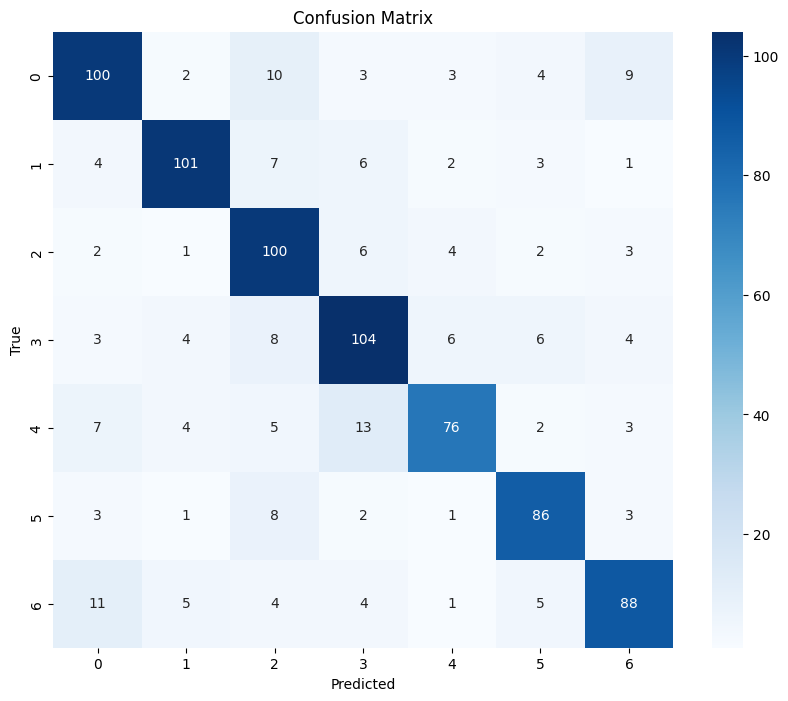

In [13]:
import seaborn as sns

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=['HDPE', 'LDPE', 'Other', 'PET', 'PP', 'PS', 'PVC']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model

In [14]:
# Save the model
model.save('plastic_classifier.h5')

# Convert to TensorFlow Lite format

In [15]:

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model
with open('plastic_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as plastic_classifier.h5")
print("TensorFlow Lite model saved as plastic_classifier.tflite")

INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmp_v1f2rnc\assets


INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmp_v1f2rnc\assets


Model saved as plastic_classifier.h5
TensorFlow Lite model saved as plastic_classifier.tflite
